# Решение задачи Коши для СОДУ

y1'(x) = y2(x)/30
y2'(x) = - y1(x)/15

In [1]:
import math
from math import cos, sin, sqrt
import numpy as np
from matplotlib import pyplot as plt

### Инициализация переменных

In [2]:
A = 1/30
B = 1/15
c2 = 1/20
x0 = 0
xk = math.pi
y0 = [B*xk, A*xk]
f0 = [A*y0[1], -B*y0[0]]
fx0 = [-A*B*y0[0], -B*A*y0[1]]
fy0 = [A, -B]

b2 = 1/(2*c2)  # 10
a21 = 1/(2*b2)  # 1/20
b1 = 1 - b2  # -9

eps = 1e-4

In [3]:
def calc_c1_c2(x, b1, b2):
    A_ = [ [ cos(x / sqrt(450)), sin(x / sqrt(450)) ], [ -30/sqrt(450)*sin(x / sqrt(450)), 30/sqrt(450)*cos(x / sqrt(450)) ] ]
    b_ = [[b1], [b2]]
    ans = np.linalg.solve(A_,b_)
    c1 = ans[0][0]
    c2 = ans[1][0]
    return (c1, c2)

In [4]:
def general_solution(x, c1, c2):
    y1 = c1 * cos(x/sqrt(450)) + c2 * sin(x/sqrt(450))
    y2 = -30/sqrt(450)*c1*sin(x/sqrt(450)) + 30/sqrt(450)*c2*cos(x/sqrt(450))
    return (y1,y2)

In [5]:
c1, c2 = calc_c1_c2(0, xk*B, xk*A)

In [6]:
y1_true, y2_true = general_solution(math.pi, c1, c2)
print(y1_true, y2_true)

0.21807312873984425 0.059868731856656046


## 1. Расчетные схемы метода Рунге-Кутты с постоянным шагом
двухэтапный, второго порядка. 
оценка полной погрешности по методу Рунге

In [7]:
def step(h, y0):
    k11 = h*A*y0[1]
    k12 = h*(-B)*y0[0]    
    k21 = h*A*(y0[1]+a21*k12)
    k22 = h*(-B)*(y0[0]+a21*k11)
    return [y0[0]+b1*k11+b2*k21, y0[1]+b1*k12+b2*k22]

In [8]:
def step_size(s, x0, xk, eps):
    delta = (1/max(x0,xk))**(s+1) + pow(sqrt((A*A*xk)**2 + ((-B)*B*xk)**2), s+1)
    h0 = (eps/delta)**(1/(s+1))
    return h0

In [9]:
# выбор начального шага
h0 = step_size(2, x0, xk, eps)
print('h =', h0)
s = 2
error = 1
X_2_const = [x0]  # points
Y_2_const = [0]  # errors
while error > eps:
    # 1. С шагом h1 = h0
    x0 = 0
    h = h0
    x1 = x0
    y1 = y0
    c1, c2 = calc_c1_c2(x1, xk*B, xk*A)
    while x1 + h < xk:
        y1 = step(h, y1)
        x1 += h
        y_true = general_solution(x1, c1, c2)
        X_2_const.append(x1)
        Y_2_const.append(sqrt((y1[0]-y_true[0])**2 + (y1[1]-y_true[1])**2))

        if x1 + h >= xk:
            h1 = xk - x1
            y1 = step(h1, y1)
            x1 += h1
            y_true = general_solution(x1, c1, c2)
            X_2_const.append(x1)
            Y_2_const.append(sqrt((y1[0]-y_true[0])**2 + (y1[1]-y_true[1])**2))
    y_h1 = y1  # y с чертой
    print('result:', y_h1)
    
    # 2. С шагом  h2 = h0/2
    h = h0/2
    x1 = x0
    y1 = y0
    while x1 + h < xk:
        y1 = step(h, y1)
        x1 += h
        if x1 + h >= xk:
            h1 = xk - x1
            y1 = step(h1, y1)
            x1 += h1
    y_h2 = y1  # y с волной
    err1 = (y_h2[0] - y_h1[0])/(2**s-1) # ~Ri0 формула (79)
    err2 = (y_h2[1] - y_h1[1])/(2**s-1) # ~Ri1
    error = math.sqrt(err1**2 + err2**2)
    print('error estimation:', error)
    print('Absolute error h=h0: ', abs(y1_true-y_h1[0]), abs(y2_true-y_h1[1]))
    print('Absolute error h=h0/2: ', abs(y1_true-y_h2[0]), abs(y2_true-y_h2[1]))

    h0 /= 2

h = 0.14581532104255834
result: [0.21807317851533886, 0.05986837894044805]
error estimation: 8.861976725175746e-08
Absolute error h=h0:  4.9775494614934246e-08 3.529162079934922e-07
Absolute error h=h0/2:  1.2480649957957723e-08 8.968577112911102e-08


## 2. Расчетные схемы метода Рунге-Кутты с автоматическим выбором шага
двухэтапный, 2-го порядка

In [10]:
# выбор начального шага
h0 = step_size(2, x0, xk, eps)
print('h =', h0)
hi = h0/2
s=2
eps = 1e-5
print('Starting point:', y0)
(y_k1, y_k2) = (y0, y0)
x1 = x0
X_2_auto = [x0]
H2 = [h0]  # значения h
errors2 = []
errors_ratio2 = [0]
while x1 + hi < xk:
    # шаг с h=hi
    y_old = y_k1
    y_new1 = step(hi, y_k1)
    # два шага с h=hi/2
    hi_1 = hi/2
    y_new2 = step(hi_1, y_k1)
    y_k2 = step(hi_1, y_new2)
    y_k1 = y_new1
    
    # вычисление оценки погрешности
    err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
    err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
    error = sqrt(err1**2 + err2**2)
    if (error > eps * pow(2,s)):
        x1 +=hi
        hi /= 2
    elif (error > eps and error <= eps * pow(2, s)):
        y_k1 = y_k2
        x1 += hi
        hi /= 2
    elif (error >= eps / pow(2,s+1) and error <= eps):
        y_k1 = y_new1
        x1 += hi
    else:
        y_k1 = y_new1
        x1 += hi
        hi = hi * 2
    c1, c2 = calc_c1_c2(X_2_auto[-1], y_old[0], y_old[1] )
    y_true = general_solution(x1, c1, c2)  # значение функции на предыдущем шаге, вычисленное в нынешней точке
    true_error = sqrt((y_k1[0]-y_true[0])**2 + (y_k1[1]-y_true[1])**2)
    X_2_auto.append(x1)
    H2.append(hi)
    errors_ratio2.append(true_error/error)
    print(true_error, error)
# последний шаг

hi = xk - x1
# шаг с h=hi
y_old = y_k1
y_new1 = step(hi, y_k1)
# два шага с h=hi/2
hi_1 = hi/2
y_new2 = step(hi_1, y_k1)
y_k2 = step(hi_1, y_new2)
y_k1 = y_new1
# вычисление оценки погрешности
err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
error = sqrt(err1**2 + err2**2)

c1, c2 = calc_c1_c2(X_2_auto[-1], y_old[0], y_old[1] )
y_true = general_solution(xk, c1, c2) 
true_error = sqrt((y_k1[0]-y_true[0])**2 + (y_k1[1]-y_true[1])**2)
errors_ratio2.append(true_error/error)
X_2_auto.append(xk)
H2.append(hi)
print('result:', y_k1)
print("Absolute error = ", y1_true - y_k1[0], y2_true - y_k1[1])

h = 0.14581532104255834
Starting point: [0.20943951023931953, 0.10471975511965977]
2.0660910585146107e-09 2.065944305188015e-09
1.6540436389485745e-08 1.6538124157642948e-08
1.3250740140805728e-07 1.324715609437725e-07
1.0628915274637864e-06 1.062355398043206e-06
8.544860137127117e-06 8.537497300500248e-06
result: [0.2180753213376704, 0.05985538137981536]
Absolute error =  -2.1925978261616574e-06 1.3350476840687242e-05


## 3.1 Расчетные схемы метода Рунге-Кутты трехэтапный, 3-го порядка
### a)  с постоянным шагом

In [11]:
def step3(h, y0):
    k11 = h*A*y0[1]
    k21 = h*(-B)*y0[0]
    
    k12 = h*A*(y0[1]+1/2*k21)
    k22 = h*(-B)*(y0[0]+1/2*k11)

    k31 = h*A*(y0[1]-k21+2*k22)
    k32 = h*(-B)*(y0[0]-k11+2*k12)
    
    return [y0[0]+1/6*(k11+4*k12+k31), y0[1]+1/6*(k21+4*k22+k32)]

In [22]:
# выбор начального шага
h0 = step_size(3, x0, xk, eps)
print('h =', h0)
s = 3
eps = 1e-4
error = 1
X_3_const = [x0]
Y_3_const = [0]
while error > eps:
    # 1. С шагом h1 = h0
    x0 = 0
    h = h0
    x1 = x0
    y1 = y0
    c1, c2 = calc_c1_c2(x1, xk*B, xk*A)
    while x1 + h < xk:
        y1 = step3(h, y1)
        x1 += h
        y_true = general_solution(x1, c1, c2)
        X_3_const.append(x1)
        Y_3_const.append(sqrt((y1[0]-y_true[0])**2 + (y1[1]-y_true[1])**2))
        #print(y_true[0]-y1[0], y_true[1]-y1[1])
        if x1 + h >= xk:
            h1 = xk - x1
            y1 = step3(h1, y1)
            x1 += h1
            y_true = general_solution(x1, c1, c2)
            X_3_const.append(x1)
            Y_3_const.append(sqrt((y1[0]-y_true[0])**2 + (y1[1]-y_true[1])**2))
    y_h1 = y1  # y с чертой
    print('result:', y_h1)
    # 2. С шагом  h2 = h0/2
    h = h0/2
    x1 = x0
    y1 = y0
    while x1 + h < xk:
        y1 = step3(h, y1)
        x1 += h
        if x1 + h >= xk:
            h1 = xk - x1
            y1 = step3(h1, y1)
            x1 += h1
    y_h2 = y1  # y с волной
    err1 = (y_h2[0] - y_h1[0])/(2**s-1) # ~Ri0 формула (79)
    err2 = (y_h2[1] - y_h1[1])/(2**s-1) # ~Ri1
    error = math.sqrt(err1**2 + err2**2)
    print('error estimation:', error)
    print('Absolute error h=h0: ', abs(y1_true-y_h1[0]), abs(y2_true-y_h1[1]))
    print('Absolute error h=h0/2: ', abs(y1_true-y_h2[0]), abs(y2_true-y_h2[1]))

    h0 /= 2

h = 0.17666455300966513
result: [0.21807312798138553, 0.05986873164104211]
error estimation: 9.843030178870802e-11
Absolute error h=h0:  7.584587125020192e-10 2.1561393642732796e-10
Absolute error h=h0/2:  9.582901139282285e-11 2.6776518502469315e-11


### б)  с автоматическим выбором шага

In [13]:
s = 3
tol1 = 1e-5 # макс допустимая локальная погрешность (tolerance)
tol2 = tol1/pow(2,s)
tol3 = tol2/pow(2,s+1)

In [14]:
# выбор начального шага
h0 = step_size(3, x0, xk, eps)
print('h =', h0)
s = 3
hi = h0
print('Starting point:', y0)
(y_k1, y_k2) = (y0, y0)
x1 = x0
X_3_auto = [x0]
H3 = [h0]
errors_ratio3 = [0]
eps = 1e-5
while x1 + hi < xk:
    # шаг с h=hi
    y_old = y_k1
    y_new1 = step3(hi, y_k1)
    
    # два шага с h=hi/2
    hi_1 = hi/2
    y_new2 = step3(hi_1, y_k1)
    y_k2 = step3(hi_1, y_new2)
    
    y_k1 = y_new1
    
    err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
    err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
    error = sqrt(err1**2 + err2**2)
    if (error > eps * pow(2,s)):
        x1 +=hi
        hi /= 2
        y_k1 = y_old
        y_k2 = y_old
    elif (error > eps and error <= eps * pow(2, s)):
        y_k1 = y_k2
        x1 += hi
        hi /= 2
    elif (error >= eps / pow(2,s+1) and error <= eps):
        y_k1 = y_new1
        x1 += hi
    else:
        y_k1 = y_new1
        x1 += hi
        hi = hi * 2
    c1, c2 = calc_c1_c2(X_3_auto[-1], y_old[0], y_old[1] )
    y_true = general_solution(x1, c1, c2)  # значение функции на предыдущем шаге, вычисленное в нынешней точке
    true_error = sqrt((y_k1[0]-y_true[0])**2 + (y_k1[1]-y_true[1])**2)  # истинная локальная погрешность 
    X_3_auto.append(x1)
    H3.append(hi)
    errors_ratio3.append(true_error/error)

# последний шаг

hi = xk - x1
# шаг с h=hi
y_old = y_k1
y_new1 = step3(hi, y_k1)
# два шага с h=hi/2
hi_1 = hi/2
y_new2 = step3(hi_1, y_k1)
y_k2 = step3(hi_1, y_new2)
y_k1 = y_new1
# вычисление оценки погрешности
err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
error = sqrt(err1**2 + err2**2)

c1, c2 = calc_c1_c2(X_3_auto[-1], y_old[0], y_old[1] )
y_true = general_solution(xk, c1, c2) 
true_error = sqrt((y_k1[0]-y_true[0])**2 + (y_k1[1]-y_true[1])**2)
errors_ratio3.append(true_error/error)
X_3_auto.append(xk)
H3.append(hi)

print('result:', y_k1)
print('error evaluation = ', error)
print("Absolute error = ", y1_true - y_k1[0], y2_true - y_k1[1])

h = 0.3141589371008173
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.21807297547469826, 0.059868679904500885]
error evaluation =  3.698893794243043e-08
Absolute error =  1.5326514599123264e-07 5.1952155161183455e-08


## 3.2 Графики зависимости истинной полной погрешности от значения независимой переменной x для двух и трехэтапных ЯМРК

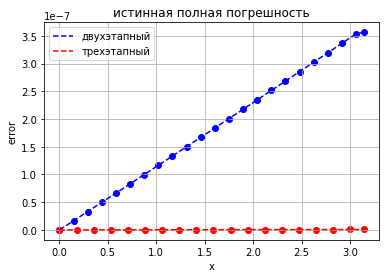

In [15]:
plt.title('истинная полная погрешность')
plt.plot(X_2_const, Y_2_const, c='blue', ls = '--', label = 'двухэтапный')
plt.scatter(X_2_const, Y_2_const, color='blue')
plt.plot(X_3_const, Y_3_const, c='red', ls = '--', label = 'трехэтапный')
plt.scatter(X_3_const, Y_3_const, color='red')

plt.xlabel('x')
plt.ylabel('error')
plt.legend()
plt.grid()

## 3.3.1 графики зависимости величины шага интегрирования от значения независимой переменной 𝑥

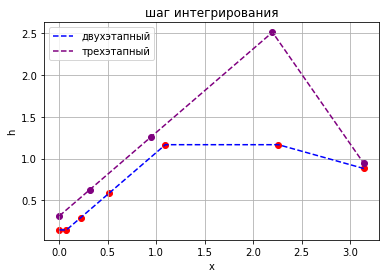

In [16]:
plt.title('шаг интегрирования')
plt.plot(X_2_auto, H2, c='blue', ls = '--', label = 'двухэтапный')
plt.scatter(X_2_auto, H2, color='red')
plt.plot(X_3_auto, H3, c='purple', ls = '--', label = 'трехэтапный')
plt.scatter(X_3_auto, H3, color='purple')
plt.xlabel('x')
plt.ylabel('h')
plt.legend()
plt.grid()

## 3.3.2 графики зависимости отношения истинной локальной погрешности к полученной  оценке локальной погрешности от значения независимой переменной x

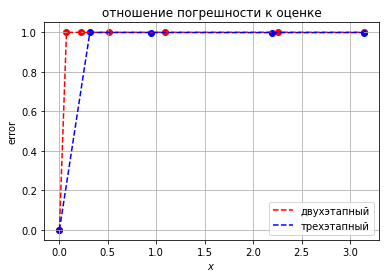

In [17]:
plt.title('отношение погрешности к оценке')
plt.plot(X_2_auto, errors_ratio2, c='red', ls = '--', label = 'двухэтапный')
plt.scatter(X_2_auto, errors_ratio2, color='red')
plt.plot(X_3_auto, errors_ratio3, c='blue', ls = '--', label = 'трехэтапный')
plt.scatter(X_3_auto, errors_ratio3, color='blue')
plt.xlabel('$x$')
plt.ylabel('error')
plt.legend()
plt.grid()

## 3.3.3 графики зависимости количества вычислений правой части системы от заданной точности 𝜀 (например, 𝜀 = 10−1, 10−2, 10−3, 10−4, 10−5 )

### а) двухэтапный порядка 2 

In [18]:
# выбор начального шага
calc_count2 = []
for i in range(1, 6):
    eps = 10**(-i)
    cnt = 0
    h0 = step_size(2, x0, xk, eps)
    print('h =', h0)
    hi = h0/2
    s=2
    print('Starting point:', y0)
    (y_k1, y_k2) = (y0, y0)
    x1 = x0
    
    while x1 + hi < xk:
        # шаг с h=hi
        y_old = y_k1
        y_new1 = step(hi, y_k1)
        # два шага с h=hi/2
        hi_1 = hi/2
        y_new2 = step(hi_1, y_k1)
        y_k2 = step(hi_1, y_new2)
        y_k1 = y_new1
    
        cnt+=3
        # вычисление оценки погрешности
        err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
        err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
        error = sqrt(err1**2 + err2**2)
        if (error > eps * pow(2,s)):
            x1 +=hi
            hi /= 2
        elif (error > eps and error <= eps * pow(2, s)):
            y_k1 = y_k2
            x1 += hi
            hi /= 2
        elif (error >= eps / pow(2,s+1) and error <= eps):
            y_k1 = y_new1
            x1 += hi
        else:
            y_k1 = y_new1
            x1 += hi
            hi = hi * 2

    # последний шаг
    hi = xk - x1
    res = step(hi, y_k1)
    
    cnt += 1
    calc_count2.append(cnt)
    print('result:', res)
    print("Absolute error = ", y1_true - res[0], y2_true - res[1])

h = 1.4581532104255834
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.21807710307544417, 0.05984550602182667]
Absolute error =  -3.974335599926659e-06 2.3225834829374015e-05
h = 0.6768147659208013
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.2180760879567535, 0.059851177360859084]
Absolute error =  -2.95921690926515e-06 1.7554495796962e-05
h = 0.3141495859922238
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.2180755698594946, 0.05985404005129859]
Absolute error =  -2.4411196503648647e-06 1.469180535745851e-05
h = 0.14581532104255834
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.2180753213376704, 0.05985538137981536]
Absolute error =  -2.1925978261616574e-06 1.3350476840687242e-05
h = 0.06768147659208014
Starting point: [0.20943951023931953, 0.10471975511965977]
result: [0.21807529795489908, 0.05985547755934875]
Absolute error =  -2.1692150548313638e-06 1.3254297307294105e-05


### б) трехэтапный порядка 3

In [19]:
# выбор начального шага
calc_count3 = []
for i in range(1, 6):
    eps = 10**(-i)
    cnt = 0
    h0 = step_size(3, x0, xk, eps)
    print('h =', h0)
    hi = h0/2
    s=3
    (y_k1, y_k2) = (y0, y0)
    x1 = x0
    
    while x1 + hi < xk:
        # шаг с h=hi
        y_old = y_k1
        y_new1 = step3(hi, y_k1)
        # два шага с h=hi/2
        hi_1 = hi/2
        y_new2 = step3(hi_1, y_k1)
        y_k2 = step3(hi_1, y_new2)
        y_k1 = y_new1
    
        cnt+=3
        # вычисление оценки погрешности
        err1 = (y_k2[0] - y_k1[0])/(1 - pow(2, -s)) # ~Ri0
        err2 = (y_k2[1] - y_k1[1])/(1 - pow(2, -s)) # ~Ri1
        error = sqrt(err1**2 + err2**2)
        if (error > eps * pow(2,s)):
            x1 +=hi
            hi /= 2
        elif (error > eps and error <= eps * pow(2, s)):
            y_k1 = y_k2
            x1 += hi
            hi /= 2
        elif (error >= eps / pow(2,s+1) and error <= eps):
            y_k1 = y_new1
            x1 += hi
        else:
            y_k1 = y_new1
            x1 += hi
            hi = hi * 2

    # последний шаг
    hi = xk - x1
    res = step3(hi, y_k1)
    
    cnt += 1
    calc_count3.append(cnt)
    print('result:', res)
    print("Absolute error = ", y1_true - res[0], y2_true - res[1])

h = 1.7666455300966513
result: [0.21807266857909482, 0.05986856142081415]
Absolute error =  4.6016074942145657e-07 1.7043584189802008e-07
h = 0.9934577885361576
result: [0.21807275364639764, 0.059868595924785314]
Absolute error =  3.7509344660846544e-07 1.35931870731687e-07
h = 0.5586623693260965
result: [0.21807296682263308, 0.05986867711067993]
Absolute error =  1.6191721116665114e-07 5.4745976113546035e-08
h = 0.3141589371008173
result: [0.21807299361620297, 0.05986868598896588]
Absolute error =  1.3512364127610255e-07 4.586769016684533e-08
h = 0.17666455300966513
result: [0.21807293877254832, 0.059868665230019755]
Absolute error =  1.8996729592157813e-07 6.662663629142251e-08


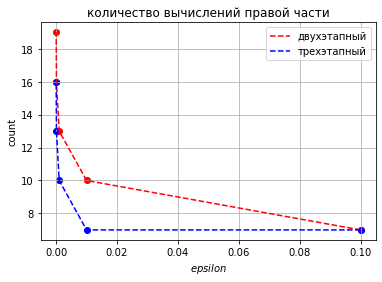

In [20]:
plt.title('количество вычислений правой части')
plt.plot([0.1, 0.01, 0.001, 0.0001, 0.00001], calc_count2, c='red', ls = '--', label = 'двухэтапный')
plt.scatter([0.1, 0.01, 0.001, 0.0001, 0.00001], calc_count2, color='red')
plt.plot([0.1, 0.01, 0.001, 0.0001, 0.00001], calc_count3, c='blue', ls = '--', label = 'трехэтапный')
plt.scatter([0.1, 0.01, 0.001, 0.0001, 0.00001], calc_count3, color='blue')
plt.xlabel('$epsilon$')
plt.ylabel('count')
plt.legend()
plt.grid()

In [21]:
print('двухэтапный', calc_count2)
print('трехэтапный', calc_count3)

двухэтапный [7, 10, 13, 16, 19]
трехэтапный [7, 7, 10, 13, 16]
